# **Project of IMA201**
Segmentation of skin lesions

*Pedro Andrade and 
Rafael Senna Benatti*

Supervisor: Pietro Gori

This work aims to develop image classification software for the diagnosis of skin lesions such as melanoma and nevus in computer-aided diagnosis systems (CADs). So, our objective is to be able, from a photo containing a skin lesion, to discriminate the pixels of the image which belong or not to the lesional region of the skin. For this, we have a dataset containing 20 dermoscopic images of melanomas and nevi, and we are inspired by the algoritmn that uses Local Bynary Pattern, as we can see in the article Dermoscopic skin lesion image segmentation based on Local Binary Pattern Clustering: Comparative study.

Bellow you can follow our whole pipeline of segmentation.

# The DataSet

The first thing we have to do is to know the Data that we are using. For dataset was available to us two sets of 10 RGB images of melanomas and nevus with the respectives segmentation masks wich will server as truth set of our problem.

Here we can see some examples of images in our datasets.

In [1]:
from skimage import io
import os, cv2, re
from matplotlib import pyplot as plt
# This function returns a list of io images from the group passed as parameter ('melanoma' or 'nevus')
def retrieve_images(lesion_type): # Parameter: 'melanoma' or 'nevus'
    im = []
    for f in os.listdir('./src/images/' + lesion_type):
        name, extension = os.path.splitext(f)
        try:
            id = str(re.findall("(\d+)$", name)[0])
            image = io.imread('src\images\\' + lesion_type + '\ISIC_'+id+'.jpg')
            im.append(image)
        except:
            pass
    return im

In [2]:
im_mel = retrieve_images('melanoma')
im_nev = retrieve_images('nevus')

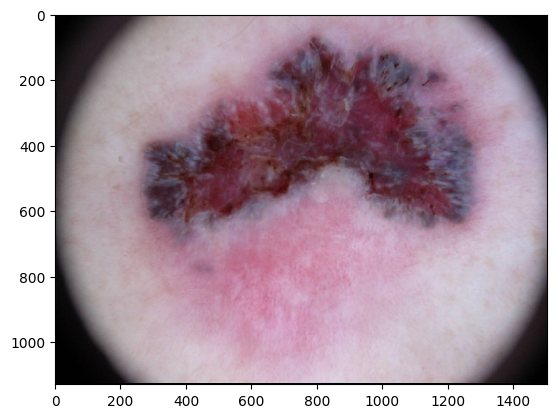

<function matplotlib.pyplot.show(close=None, block=None)>

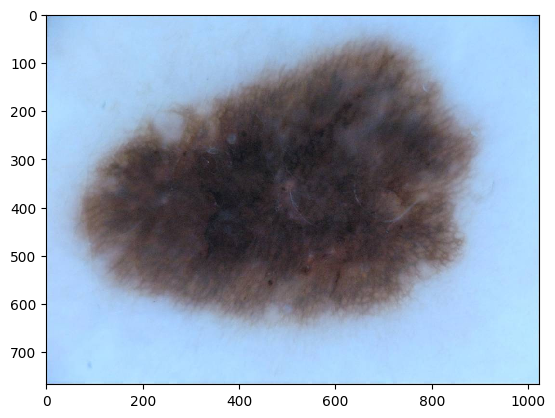

In [3]:
plt.imshow(im_mel[0], interpolation='nearest')
plt.show()
plt.imshow(im_nev[0], interpolation='nearest')
plt.show

As we can observe, the lesions are concentrated in the center of the image and in some examples we can see a circular border arround the skin due to the dermoscopic devices. These are some caracteristics that we need to have in mind when we develop our solution.

Now lets take a look in the segmentation masks already produced.

In [4]:
# This function returns an array of segmented io images from the group passed as parameter ('melanoma' or 'nevus')
def retrieve_segmentations(lesion_type):
    im = []
    for f in os.listdir('./src/images/'+ lesion_type):
        name, extension = os.path.splitext(f)
        id = str(re.findall("\d+", name)[0])
        im.append(io.imread('src\images\\' + lesion_type + '\ISIC_'+id+'_Segmentation.png'))
    return im

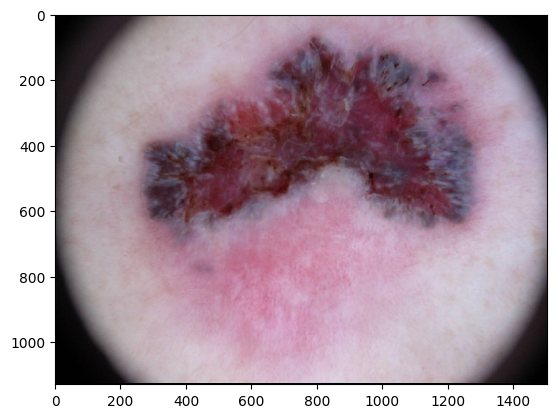

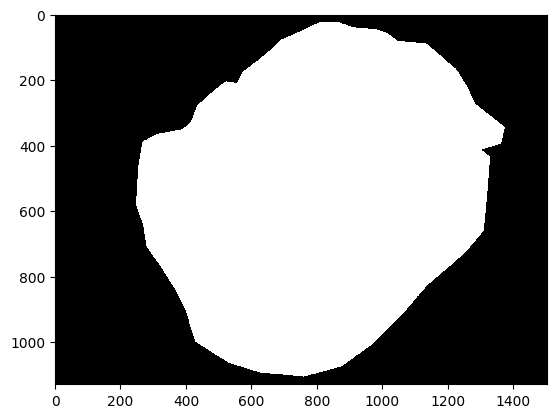

In [5]:
masks_truth = retrieve_segmentations('melanoma')
plt.imshow(im_mel[0], interpolation='nearest')
plt.show()
plt.imshow(masks_truth[0], cmap='gray',interpolation='nearest')
plt.show()

# Preprocessing process

For preprocessing step of our pipeline we have thought in two main preprocessing process that can inprove the already good results that the LGP Clustering process can achieve. First, we have to deal with the cases wich images comes with the dark border of the dermoscopy device, so would be a good first step to only apply transformations and segmentations in the Region of interest (ROIs) that we can actually find the leasures, to do that we've used morphologic openning operations. Last but not least, it's also important to eliminate the impact that the hairs in the skin can provoke, to do that we have used the algorithm proposed in the article .....

*Border Removal*

In [52]:
from PIL import Image
def find_contours(im):
    all_contours = []
    for img in im:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]
        #open morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (300,300))
        morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        #aux = Image.fromarray(morph)

        all_contours.append(morph)
    return all_contours

In [53]:
borders = find_contours(im_mel)


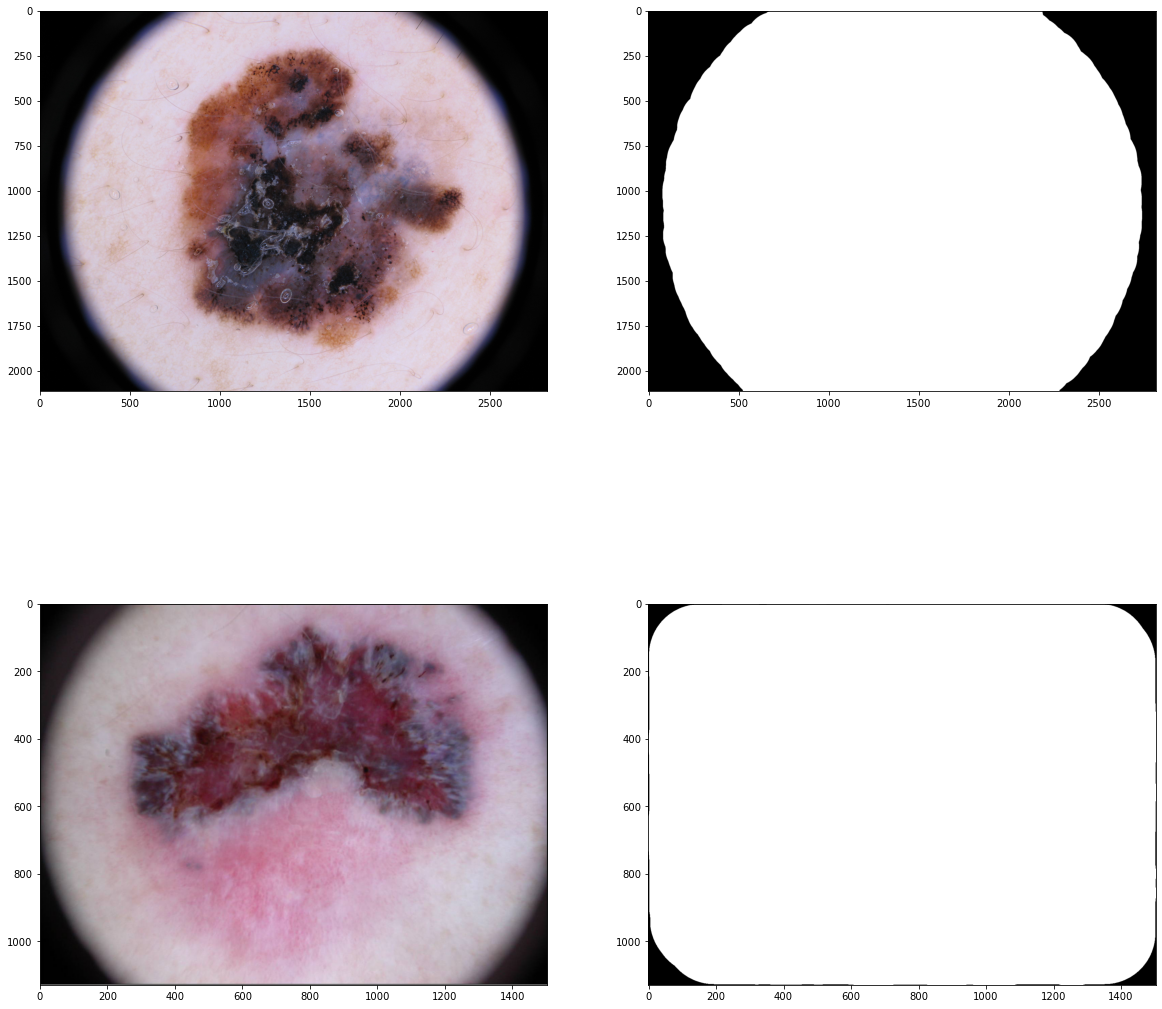

In [54]:
fig,ax = plt.subplots(2, 2, figsize=(20,20))
aux = [im_mel[3], borders[3], im_mel[0], borders[0]]
for i in range(4):
    ax[i//2,i%2].imshow(aux[i],cmap = "gray")
plt.show()

*Hair removal*

# Segmentation

Now for our main part, we'll implement the segmentation using LBP

In [9]:
import numpy as np
from skimage import feature
from skimage import filters

In [10]:
# This function returns a list of the id of the images gro the group passed as parameter
def get_id_list(lesion_type): # 'melanoma' or 'nevus'
    id_list = []
    for f in os.listdir('./src/images/' + lesion_type):
        name, extension = os.path.splitext(f)
        try:
            id = str(re.findall("(\d+)$", name)[0])
            id_list.append(id)
        except:
            pass

    return id_list

In [11]:
def lbp(img, r, num):
    # Obs.: Essa função tá retornando valores invertidos em relação ao esperado pela descrição dada nos artigos
    # De acordo com os artigos, dentro da lesão deveríamos ter mais 1s e fora mais 0s
    img = np.asarray(img)
    img = img.astype(float)
    #img = img[:,:,0] * 0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11
    # Ajustando pra valores da referência [6] do paper:
    img = img[:, :, 0] * 0.2989 + img[:, :, 1] * 0.5870 + img[:, :, 2] * 0.1140

    img = img.astype(np.uint8)

    i_min = np.min(img)
    i_max = np.max(img)

    lbp = feature.local_binary_pattern(img, num, r, method='uniform') # Falta checar se esse é o método que a gnt quer mesmo, o artigo fala um pouco sobre rotação

    return img, lbp

def binary_lbp(img, r, num):
    Y, lbp_temp = lbp(img, r, num)
    return Y, np.around(lbp_temp/np.max(lbp_temp))

def gaussian_lbp(img, r, num):
    Y, lbp = binary_lbp(img, r, num)
    return Y, (filters.gaussian(lbp, sigma=3) * 255)

In [12]:
from skimage import color

def lab_color_space(Y, L):
    img = LYL(Y, L)
    img = color.rgb2lab(img)
    return img

def LYL(Y, L):
    shape = (Y.shape[0], Y.shape[1], 3)
    img = np.empty(shape)
    img[:, :, 0] = L
    img[:, :, 1] = Y
    img[:, :, 2] = L
    return img

def ab_color_space(Y, L):
    input_image = lab_color_space(Y, L)
    shape = (Y.shape[0], Y.shape[1], 2)
    img = np.empty(shape)
    img[:, :, 0] = input_image[:, :, 1]
    img[:, :, 1] = input_image[:, :, 2]
    return img

In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def recreate_image_colorful(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def kmeans(img, n_class):
    img = np.array(img, dtype=np.float64) / 255
    # Load Image and transform to a 2D numpy array.
    w, h = original_shape = tuple(img.shape)
    d = 1
    image_array = np.reshape(img, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:100]
    kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    img = recreate_image(kmeans.cluster_centers_, labels, w, h)
    return img

def kmeans_colors(img, n_colors):
    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:100]
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    img = recreate_image_colorful(kmeans.cluster_centers_, labels, w, h)
    return img

def cluster(img):
    shape = (img.shape[0], img.shape[1])
    X = np.array(img[:, :, 0])
    X.reshape(shape)
    X = (X/np.max(X)).astype(int)
    print(X)
    return X


In [14]:
import skimage.morphology as morpho  
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

def my_perimeter(im):
    se=morpho.disk(1)
    dil=morpho.dilation(im,se)
    diff=dil-im
    ta=np.nonzero(diff)
    return ta

def create_mask(im, thresh=0.85, rayon=9, show_clustering=0):
    m0 = im[:, :].max()
    iterCounter = 0
    while ((m0 > (0.2 * im[:, :].max()) or s0 == 0) or np.isnan(m0) == True):
        center = get_center_pixel(im)
        x0 = center[0]
        y0 = center[1]
        mask=np.zeros((len(im[0]),len(im[1])))
        mask[y0,x0]=255
        ext=im[y0-rayon:y0+rayon+1,x0-rayon:x0+rayon+1]
        m0=np.mean(ext)
        s0=np.std(ext)
        if iterCounter > 1000:
            print("Reached stop condition")
            x0 = im.shape[1] // 2
            y0 = im.shape[0] // 2
            mask=np.zeros((len(im[0]),len(im[1])))
            mask[y0,x0]=255
            ext=im[y0-rayon:y0+rayon+1,x0-rayon:x0+rayon+1]
            m0=np.mean(ext)
            s0=np.std(ext)
            print(m0)
            print(s0)
            break
        print(m0)
        print(s0)
        iterCounter += 1
    modif=1
    iter = 0 
    while modif >  0:
        iter=iter+1
        modif=0
        per=my_perimeter(mask)
        for i in range (0 , len(per[0])):
            y=per[0][i]
            x=per[1][i]
            ext=im[y-rayon:y+rayon+1,x-rayon:x+rayon+1]
            m=np.mean(ext)
            s=np.std(ext)
            if np.abs(m0-m) < thresh * s0 :
                mask[y][x]=255
                modif=1
        if(show_clustering):
            cv2.imshow('frame',mask)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    return mask

def plot_superposition(im, mask):
    plt.figure('superposition')
    plt.imshow(im, cmap='gray') # I would add interpolation='none'
    plt.imshow(mask, cmap='jet', alpha=0.5) # interpolation='none'
    plt.show()

# Check if the pixel in the center of the image is part of the lesion (wether it's black)
# If it's not, searchs for a black pixel in the image
# Returns a tuple with the  pixel coordinates
def get_center_pixel(im):
    print("Called function get_center_pixel")
    x0 = im.shape[0]//2
    y0 = im.shape[1]//2
    center=(x0, y0)
    centerPixel  = im[x0][y0]
    threshold = 0.8 * im[:, :].max()
    minimum = im[:, :].min()
    side = int(0.4 * min([im.shape[0], im.shape[1]]))
    print(im.shape)
    while (centerPixel != minimum):
        x0 = random.randint(0, im.shape[0] - 1)
        y0 = random.randint(0, im.shape[1] - 1)
        centerPixel  = im[x0][y0]
        center=(x0, y0)
    return center


In [19]:
from skimage.transform import resize

# This code is currently using parallel processes, so, the main function calls the function below.
def main_task(img_array, img_index, lesion_type):
    id = get_id_list(lesion_type)
    r = 3
    num = 20 * r

    # This implementation returns the Y scale of the original image without the application of a gaussian filter and
    # the image itself after a LBP, binarization and application of a gaussian filter
    Y, tgaussian_lbp = gaussian_lbp(img_array[img_index], r, num)

    # This function returns the LBP treated image in a LAB color space
    lab_image = lab_color_space(Y, tgaussian_lbp)

    # This fucntion returns the image after the application of kmeans.
    # It is evident that this is not optimal, we must try to apply the kmeans algorithm only one time.
    clustered = kmeans(cluster(kmeans_colors(lab_image, 2)), 2)

    resizingFactor = 3 # to don't resize, use 1
    clustered = resize(clustered, (clustered.shape[0]//resizingFactor, clustered.shape[1]//resizingFactor))
    plt.imshow(clustered, cmap='gray')
    plt.show()
    clustered = create_mask(clustered, thresh=0.91, rayon=50//(resizingFactor), show_clustering=1)

    # The line below is used to save the images inside the folder ./out
    io.imsave('out/'+ lesion_type + '/mask_' + id[img_index] + '.png', clustered)
    print(f'Saved image with id: {id[img_index]}')

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


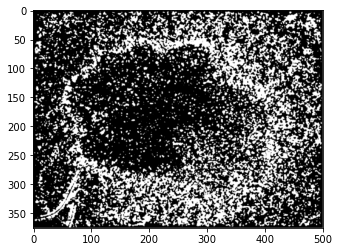

Called function get_center_pixel
(376, 501)
nan
nan
Called function get_center_pixel
(376, 501)
0.0006056653694766709
0.0011885779678164345


c:\Users\pedro\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pedro\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pedro\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pedro\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pedro\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warn

Saved image with id: 0000046


: 

In [20]:
main_task(im_mel, 1, 'melanoma')